# Simplest pytorch GAN implementation

Without essential code and not to many comments.

For a verbose description of a similar algorithm you can have a look here: 
- https://github.com/christianversloot/machine-learning-articles/blob/main/building-a-simple-vanilla-gan-with-pytorch.md

## Initialisation

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
latent_dim = 100
num_epochs = 50
batch_size = 128
lr = 0.0002
beta1 = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Definition of neural networks

In [5]:


# Generator Class for a Basic GAN
class Generator(nn.Module):
    """
    Vanilla GAN Generator
    """
    def __init__(self):
        super().__init__()  # Call the superclass constructor
        # Define the layers of the generator
        self.layers = nn.Sequential(
          # First layer: Upsampling from latent dimension to 128 features
          nn.Linear(latent_dim, 128, bias=False),  # No bias to simplify the network
          nn.BatchNorm1d(128, 0.8),  # Batch normalization to stabilize training
          nn.LeakyReLU(0.25),  # Activation function with negative slope

          # Second layer: Upsampling to 256 features
          nn.Linear(128, 256, bias=False),
          nn.BatchNorm1d(256, 0.8),
          nn.LeakyReLU(0.25),

          # Third layer: Upsampling to 512 features
          nn.Linear(256, 512, bias=False),
          nn.BatchNorm1d(512, 0.8),
          nn.LeakyReLU(0.25),

          # Final layer: Upsampling to match the target data dimension
          nn.Linear(512, 28 * 28, bias=False),  # Output shape for MNIST-like data (784 pixels)
          nn.Tanh()  # Activation function to scale output to [-1, 1] (image generation)
        )

    def forward(self, x):
        """Forward pass through the generator"""
        return self.layers(x)  # Pass the input through all the defined layers


# Discriminator Class for a Basic GAN
class Discriminator(nn.Module):
    """
    Vanilla GAN Discriminator
    """
    def __init__(self):
        super().__init__()  # Call the superclass constructor
        # Define the layers of the discriminator
        self.layers = nn.Sequential(
          # Input layer: Flatten and process 28x28 images (784 pixels)
          nn.Linear(28 * 28, 1024), 
          nn.LeakyReLU(0.25),  # Activation function with negative slope

          # Second layer: Processing to 512 features
          nn.Linear(1024, 512), 
          nn.LeakyReLU(0.25),

          # Third layer: Processing to 256 features
          nn.Linear(512, 256), 
          nn.LeakyReLU(0.25),

          # Final output layer: Probability that the image is real or fake
          nn.Linear(256, 1), 
          nn.Sigmoid()  # Sigmoid activation for probability output (0 to 1)
        )

    def forward(self, x):
        """Forward pass through the discriminator"""
        x = x.view(-1, 28 * 28)  # Flatten the input data
        return self.layers(x)  # Pass through all layers


# Instantiate the Generator and Discriminator, moving them to the specified device (CPU/GPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define the loss function and optimizers for GAN training
criterion = nn.BCELoss()  # Binary cross-entropy for binary classification (real/fake)
g_optimizer = torch.optim.AdamW(generator.parameters(), lr=lr, betas=(beta1, 0.999))  # Generator optimizer
d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))  # Discriminator optimizer


## Get MNIST data

In [6]:
# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Training of the GAN

In [7]:
# Train the GAN
# Lists to track the losses during training
g_loss_all = []  # Generator loss history
d_loss_all = []  # Discriminator loss history

# Main training loop for GAN
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # Move the real images to the specified device
        real_images = real_images.to(device)
        actual_batch_size = real_images.size(0)  # Get the actual batch size
        real_labels = torch.ones(actual_batch_size, 1).to(device)  # Labels for real images (1)
        
        # Train the discriminator on real images
        d_optimizer.zero_grad()  # Zero the gradients
        d_outputs_real = discriminator(real_images)  # Discriminator output for real images
        d_loss_real = criterion(d_outputs_real, real_labels)  # Loss for real images
        d_loss_real.backward()  # Backpropagation
        d_optimizer.step()  # Update discriminator weights
        
        # Train the discriminator on fake images
        z = torch.randn(actual_batch_size, latent_dim).to(device)  # Generate random noise
        fake_images = generator(z)  # Generate fake images from noise
        fake_labels = torch.zeros(actual_batch_size, 1).to(device)  # Labels for fake images (0)
        d_outputs_fake = discriminator(fake_images.detach())  # Discriminator output for fake images
        d_loss_fake = criterion(d_outputs_fake, fake_labels)  # Loss for fake images
        d_loss_fake.backward()  # Backpropagation
        d_optimizer.step()  # Update discriminator weights
        
        # Train the generator to fool the discriminator
        g_optimizer.zero_grad()  # Zero the gradients
        z = torch.randn(actual_batch_size, latent_dim).to(device)  # Generate random noise again
        fake_images = generator(z)  # Create fake images
        d_outputs = discriminator(fake_images)  # Discriminator output for these fake images
        g_loss = criterion(d_outputs, real_labels)  # Generator loss (aim to fool the discriminator)
        g_loss.backward()  # Backpropagation
        g_optimizer.step()  # Update generator weights
        
        # Print the losses for tracking progress
        if (i + 1) % 100 == 0:  # Display every 100 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"Discriminator Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, "
                  f"Generator Loss: {g_loss.item():.4f}")
            # Record the losses for visualization later
            g_loss_all.append(g_loss.item())
            d_loss_all.append(d_loss_real.item() + d_loss_fake.item())


Epoch [1/50], Step [100/469], Discriminator Loss: 0.6747, Generator Loss: 1.3857
Epoch [1/50], Step [200/469], Discriminator Loss: 0.8209, Generator Loss: 1.6651
Epoch [1/50], Step [300/469], Discriminator Loss: 0.9535, Generator Loss: 3.5242
Epoch [1/50], Step [400/469], Discriminator Loss: 1.2224, Generator Loss: 2.8242
Epoch [2/50], Step [100/469], Discriminator Loss: 0.6156, Generator Loss: 1.9905
Epoch [2/50], Step [200/469], Discriminator Loss: 1.0134, Generator Loss: 0.8472
Epoch [2/50], Step [300/469], Discriminator Loss: 1.0199, Generator Loss: 0.7748
Epoch [2/50], Step [400/469], Discriminator Loss: 0.8260, Generator Loss: 0.8761
Epoch [3/50], Step [100/469], Discriminator Loss: 0.4716, Generator Loss: 2.2733
Epoch [3/50], Step [200/469], Discriminator Loss: 0.8063, Generator Loss: 3.8924
Epoch [3/50], Step [300/469], Discriminator Loss: 0.4589, Generator Loss: 3.0242
Epoch [3/50], Step [400/469], Discriminator Loss: 0.3937, Generator Loss: 2.2631
Epoch [4/50], Step [100/469]

Epoch [26/50], Step [200/469], Discriminator Loss: 0.5769, Generator Loss: 2.1710
Epoch [26/50], Step [300/469], Discriminator Loss: 0.6918, Generator Loss: 2.1216
Epoch [26/50], Step [400/469], Discriminator Loss: 0.6306, Generator Loss: 1.7000
Epoch [27/50], Step [100/469], Discriminator Loss: 0.6227, Generator Loss: 1.5216
Epoch [27/50], Step [200/469], Discriminator Loss: 0.6115, Generator Loss: 2.1823
Epoch [27/50], Step [300/469], Discriminator Loss: 0.7414, Generator Loss: 2.1299
Epoch [27/50], Step [400/469], Discriminator Loss: 0.5900, Generator Loss: 1.9240
Epoch [28/50], Step [100/469], Discriminator Loss: 0.6191, Generator Loss: 2.0884
Epoch [28/50], Step [200/469], Discriminator Loss: 0.6160, Generator Loss: 1.6644
Epoch [28/50], Step [300/469], Discriminator Loss: 0.6484, Generator Loss: 1.8447
Epoch [28/50], Step [400/469], Discriminator Loss: 0.6242, Generator Loss: 1.7501
Epoch [29/50], Step [100/469], Discriminator Loss: 0.6151, Generator Loss: 1.7785
Epoch [29/50], S

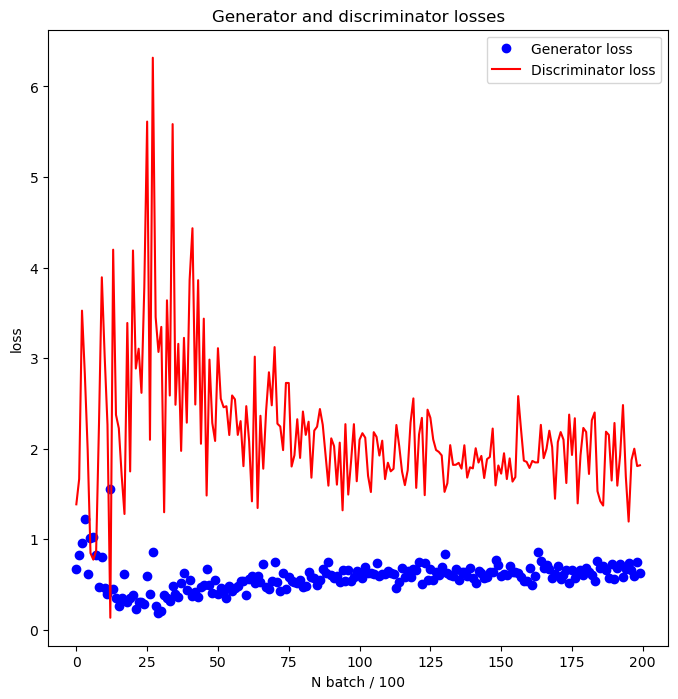

In [8]:
# Plot model performance
xrange = range(len(g_loss_all))
plt.figure(figsize=(8, 8))
plt.plot(xrange, g_loss_all, 'bo', label='Generator loss')
plt.plot(xrange, d_loss_all, 'r-', label='Discriminator loss')
plt.title('Generator and discriminator losses')
plt.xlabel('N batch / %d' % 100)
plt.ylabel('loss')
plt.legend()

## Now generate new images

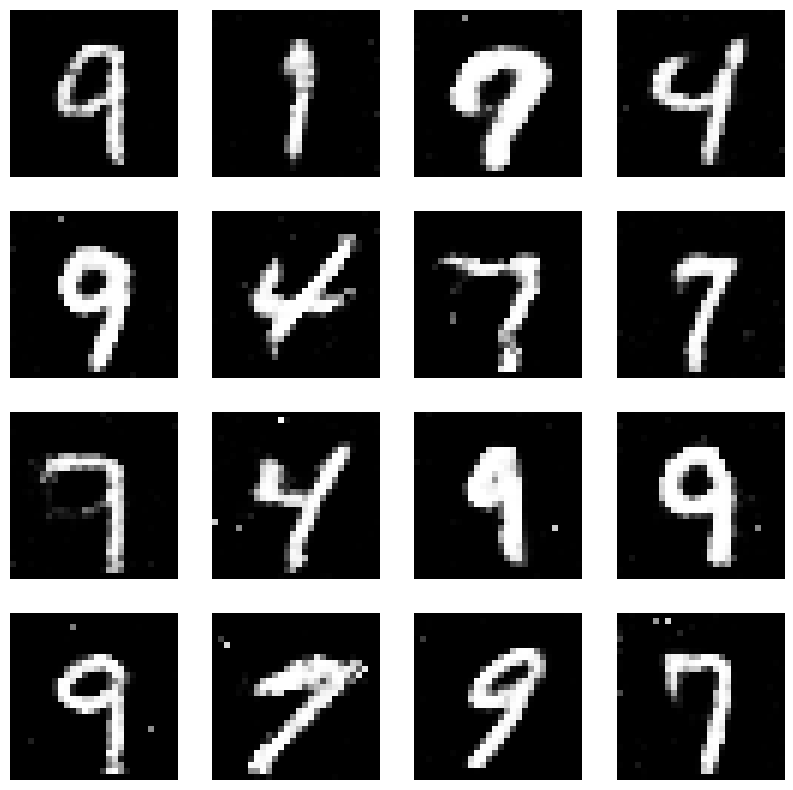

In [10]:
# Generate a batch of random noise vectors
z = torch.randn(batch_size, latent_dim).to(device)  # Random noise (latent vectors)
images = generator(z).cpu().detach().numpy()  # Generate images, convert to numpy array

# Create a new figure to plot the generated images
plt.figure(figsize=(10, 10))  # Adjust the figure size for larger display
for i in range(16):  # Display the first 16 generated images
    image = images[i]  # Extract the i-th image from the generated batch
    image = np.reshape(image, (28, 28))  # Reshape the flattened image to 28x28 (like MNIST)
    
    # Plot the image in a 4x4 grid (16 subplots)
    plt.subplot(4, 4, i + 1)  # Create a subplot for the current image
    plt.imshow(image, cmap='gray')  # Display the image in grayscale
    plt.axis('off')  # Hide the axis ticks and labels to focus on the image

# Show the plot with all the generated images
plt.show()
